# Identifying and Predicting Fraudulent Transactions in Financial Payment Service Data

Felix van Kleef, Kelechi Isiugo, Robin Lee, Sebastian Rivera

---



In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_almost_equal
import kagglehub
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, r2_score
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score, average_precision_score

#-------------------------------------------------------------------------------------------------------------------------------------------
# Download latest version of the fraud data
#-------------------------------------------------------------------------------------------------------------------------------------------
path = kagglehub.dataset_download("arunavakrchakraborty/financial-payment-services-fraud-data")


#-------------------------------------------------------------------------------------------------------------------------------------------
# Get the list of files in the directory
#-------------------------------------------------------------------------------------------------------------------------------------------
files = os.listdir(path)

print("File names:")
for file in files:
    print(file)


#-------------------------------------------------------------------------------------------------------------------------------------------
# Read the CSV file
#-------------------------------------------------------------------------------------------------------------------------------------------
df_entire_data = pd.read_csv(path + "/Fraud.csv")
df = pd.read_csv("Fraud.csv") #1M subset
df = df[['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud']]
#--------------------------------------------------------------------------------------------------------------------------------------------
# Generate 1000 random samples with the same fraud rate for inspection
#---------------------------------------------------------------------------------------------------------------------------------------------

# Define sample sizes
total_samples = 1000
fraud_ratio = 0.01  # 1% fraud
non_fraud_ratio = 0.99  # 99% non-fraud

fraud_sample_size = int(total_samples * fraud_ratio)  # 1% of 1000 = 10
non_fraud_sample_size = total_samples - fraud_sample_size  # 99% of 1000 = 990

# Separate fraud and non-fraud cases
fraud_cases = df_entire_data[df_entire_data['isFraud'] == 1].sample(n=fraud_sample_size, random_state=42, replace=True)  # Ensuring enough fraud cases
non_fraud_cases = df_entire_data[df_entire_data['isFraud'] == 0].sample(n=non_fraud_sample_size, random_state=42)

# Combine both samples
df_sampled = pd.concat([fraud_cases, non_fraud_cases]).sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

# Check class distribution
print(df_sampled['isFraud'].value_counts(normalize=True))  # Should be ~99% non-fraud, ~1% fraud


df_sampled.to_csv('fraud_thousand_subset.csv', index=False)


print(df.shape)
df.head()


100%|██████████| 178M/178M [00:01<00:00, 101MB/s]

Extracting files...


File names:
Fraud.csv
(208226, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


# 1. Exploratory Data Analysis

## 1.1 Default Dataframe


**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** - amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [ ]:
blank_counts = df.isin(['', None, np.nan]).sum()
print(blank_counts)

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


* **There are no missing records in the data**

In [ ]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [ ]:
df.describe(include='object')

,type,nameOrig,nameDest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C1902386530,C1286084959
freq,2237500,3,113


In [ ]:
df['isFraud'].value_counts(normalize=True)

,proportion
isFraud,
0,0.998709
1,0.001291


* **The data has 99.89% non-fraud and 1.09% fraud transactions**

## 1.2 Feature Engineering

In [ ]:
df_feature_engineered = df.copy() #save a copy of the data for feature engineering

In [ ]:
# --- TIME-BASED FEATURES ---
# Importance: Fraudulent transactions often occur at unusual times, such as late at night.
# Extracts the hour and day of the week for analysis
df_feature_engineered['hour_of_day'] = ((df_feature_engineered['step'] - 1) % 24) + 1  # Adjusting to range 1-24 correctly
df_feature_engineered['day_of_week'] = ((df_feature_engineered['step'] - 1) // 24) + 1  # Ensuring the day changes correctly when hour resets to 1

# Consider followig: Computes the time difference between transactions for the same sender
# data['time_since_last_transaction'] = data.groupby('nameOrig')['step'].diff()
#- Need to check since now first transaction is NaN which could cause problem in analysis

### 1.2.1 Merchant Identification


In [ ]:
# Importance: Fraudsters usually target personal accounts rather than merchants.
df_feature_engineered['is_sender_merchant'] = df_feature_engineered['nameOrig'].str.startswith('M').astype(int)
df_feature_engineered['is_receiver_merchant'] = df_feature_engineered['nameDest'].str.startswith('M').astype(int)

# Get the first letter in nameOrig
df_feature_engineered['nameOrig_Letter'] = df_feature_engineered['nameOrig'].str[0]

# Get the first letter in nameDest
df_feature_engineered['nameDest_Letter'] = df_feature_engineered['nameDest'].str[0]


# Count the characters in nameOrig
df_feature_engineered['nameOrig_Characters'] = df_feature_engineered['nameOrig'].str.len()


# Count the characters in nameDest
df_feature_engineered['nameDest_Characters'] = df_feature_engineered['nameDest'].str.len()



#df_feature_engineered['same_sender_receiver'] = (df_feature_engineered['nameOrig'] == df_feature_engineered['nameDest']).astype(int) #sender and receiver are never the same here

### 1.2.2 Identifying Loops and Money Laundering

In [ ]:
# --- IDENTIFYING LOOPS & MONEY LAUNDERING ---
# Importance: Detects potential money laundering by identifying accounts that send to multiple unique recipients
df_feature_engineered['orig_sends_to_multiple_dest'] = df_feature_engineered.groupby('nameOrig')['nameDest'].transform('nunique')
# Detects accounts that receive money from multiple unique senders
df_feature_engineered['dest_receives_from_multiple_orig'] = df_feature_engineered.groupby('nameDest')['nameOrig'].transform('nunique')
# Identifies accounts that both send and receive money from the same counterpart
df_feature_engineered['has_cycled_transaction'] = df_feature_engineered.duplicated(subset=['nameOrig', 'nameDest'], keep=False).astype(int)

### 1.2.3 Balance Change Features


In [ ]:
# --- BALANCE CHANGE FEATURES ---
# Importance: Fraudulent transactions often involve draining accounts completely.
# Computes balance change for the sender
df_feature_engineered['orig_balance_change'] = df_feature_engineered['oldbalanceOrg'] - df_feature_engineered['newbalanceOrig']
# Computes balance change for the recipient
df_feature_engineered['dest_balance_change'] = df_feature_engineered['newbalanceDest'] - df_feature_engineered['oldbalanceDest']

### 1.2.4 Transaction Frequency Analysis (cumulative count)

In [ ]:
# --- TRANSACTION FREQUENCY ANALYSIS (CUMULATIVE COUNT) ---
# Importance: Fraudulent accounts often conduct rapid, repeated transactions.
# Tracks the cumulative number of transactions initiated by each sender
df_feature_engineered['orig_num_transactions'] = df_feature_engineered.groupby('nameOrig').cumcount() + 1
# Tracks the cumulative number of transactions received by each recipient
df_feature_engineered['dest_num_transactions'] = df_feature_engineered.groupby('nameDest').cumcount() + 1

### 1.2.5 Suspicious Transaction Flags

In [ ]:
# --- SUSPICIOUS TRANSACTION FLAGS ---
# Importance: Emptying an account in a single transaction is highly suspicious.
df_feature_engineered['is_orig_emptying_account'] = (df_feature_engineered['newbalanceOrig'] == 0).astype(int)
df_feature_engineered['is_dest_emptying_account'] = (df_feature_engineered['newbalanceDest'] == 0).astype(int)

### 1.2.6 Payment Type Indicators

In [ ]:
df_feature_engineered['cash_out'] = df_feature_engineered['type'].apply(lambda x: 1 if x == 'CASH_OUT' else 0)
df_feature_engineered['payment'] = df_feature_engineered['type'].apply(lambda x: 1 if x == 'PAYMENT' else 0)
df_feature_engineered['cash_in'] = df_feature_engineered['type'].apply(lambda x: 1 if x == 'CASH_IN' else 0)
df_feature_engineered['transfer'] = df_feature_engineered['type'].apply(lambda x: 1 if x == 'TRANSFER' else 0)
df_feature_engineered['debit'] = df_feature_engineered['type'].apply(lambda x: 1 if x == 'DEBIT' else 0)

df_feature_engineered.drop(columns=['type'], inplace=True)

<br>

# 2. Resampling Method 1: Undersampling Process

Undersampling is a technique used to balance imbalanced datasets by reducing the number of samples from the majority class to match or approach the size of the minority class. This can help improve model performance, especially when dealing with datasets where one class significantly outnumbers the others. 

## 2.1 Creating Train, Test and Validation Data

In [ ]:
#Remove variables that represent unique IDs (or almost unique IDs). This is done because they will not be used in the models
df_modeling = df_feature_engineered.drop(['nameOrig', 'nameDest'], axis = 1).copy()
categoriacal_vars = list(df_modeling.select_dtypes(['object']).columns)
#encode categorical variables
df_modeling_encoded = pd.get_dummies(df_modeling, columns=categoriacal_vars).astype(int)

# Subset of 99% of fraud data
df_modeling_subset_fraud = df_modeling_encoded[df_modeling_encoded['isFraud'] == 1].sample(frac=0.99, random_state=42).copy()

# Subset of all non-fraud data
df_modeling_subset_nonfraud = df_modeling_encoded[df_modeling_encoded['isFraud'] == 0].copy()

# Count of records that are labeled as fraud
fraud_count = df_modeling_subset_fraud.shape[0]

# Obtain a random sample of non-fraud data - the same count as fraud
df_modeling_subset_nonfraud_sample = df_modeling_subset_nonfraud.sample(n=fraud_count*2, random_state=42).copy()

# Create balanced training set (undersampling non-fraud to get a balanced data)
df_modeling_balanced = pd.concat([df_modeling_subset_fraud, df_modeling_subset_nonfraud_sample], axis=0).reset_index(drop=True)

# Create validation set (these are raw records that are not used in the undersampling process)
df_modeling_subset_fraud_val = df_modeling_encoded[df_modeling_encoded['isFraud'] == 1].drop(df_modeling_subset_fraud.index).copy()
df_modeling_subset_nonfraud_val = df_modeling_subset_nonfraud.drop(df_modeling_subset_nonfraud_sample.index).copy()
df_modeling_val = pd.concat([df_modeling_subset_fraud_val, df_modeling_subset_nonfraud_val], axis=0).reset_index(drop=True)


# Create train and test set: Split df_modeling_balanced into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_modeling_balanced.drop('isFraud', axis=1), df_modeling_balanced['isFraud'], test_size=0.2, random_state=42)


In [ ]:
#df_modeling_balanced.info()

**In the balanced dataset, fraud rate is 50%***

In [ ]:
df_modeling_balanced['isFraud'].value_counts(normalize=True)

,proportion
isFraud,
0,0.666667
1,0.333333


#### Fraud Rate Percentage in Training Data

In [ ]:
(len(y_train[y_train==1].copy())/y_train.shape[0])*100

33.28379624884698

#### Fraud Rate Percentage in Testing Data

In [ ]:
(len(y_test[y_test==1].copy())/y_test.shape[0])*100

33.53146136503382

#### Fraud Rate Percentage in Validation Data

In [ ]:
#len(y_test[y_test==1].copy())/y_test.shape[0]
(len(df_modeling_val[df_modeling_val['isFraud']==1].copy())/df_modeling_val.shape[0])*100

0.0012937371918045851

## 2.2 Modeling with Undersampled Data (~fraud rate 50%)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Performance:
Testing Accuracy: 0.9330
Testing AUC: 0.9739
Testing AUC-PR: 0.9642
Testing Precision: 0.9645
Testing Recall: 0.8307
Testing Specificity: 0.0154
Testing F1-score: 0.8926
ROC Curve of Test Set


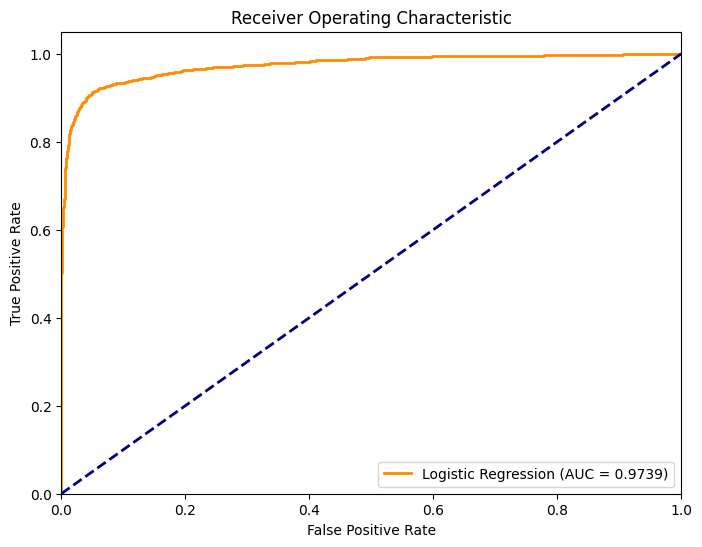


Gradient Boosting Performance:
Testing Accuracy: 0.9902
Testing AUC: 0.9984
Testing AUC-PR: 0.9979
Testing Precision: 0.9847
Testing Recall: 0.9859
Testing Specificity: 0.0077
Testing F1-score: 0.9853
ROC Curve of Test Set


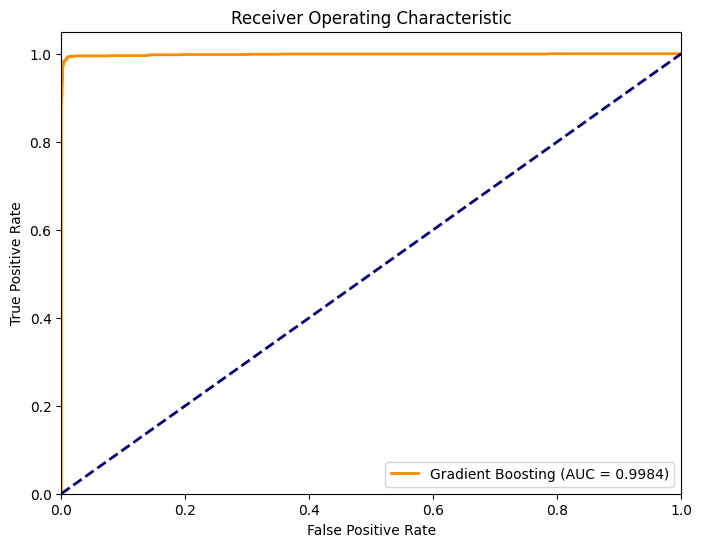


Decision Tree Performance:
Testing Accuracy: 0.9910
Testing AUC: 0.9903
Testing AUC-PR: 0.9772
Testing Precision: 0.9848
Testing Recall: 0.9884
Testing Specificity: 0.0077
Testing F1-score: 0.9866
ROC Curve of Test Set


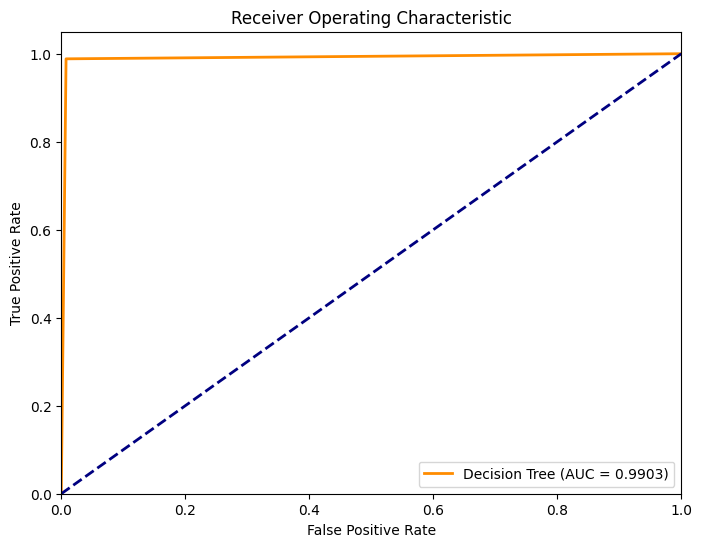


Random Forest Performance:
Testing Accuracy: 0.9926
Testing AUC: 0.9992
Testing AUC-PR: 0.9988
Testing Precision: 0.9890
Testing Recall: 0.9890
Testing Specificity: 0.0056
Testing F1-score: 0.9890
ROC Curve of Test Set


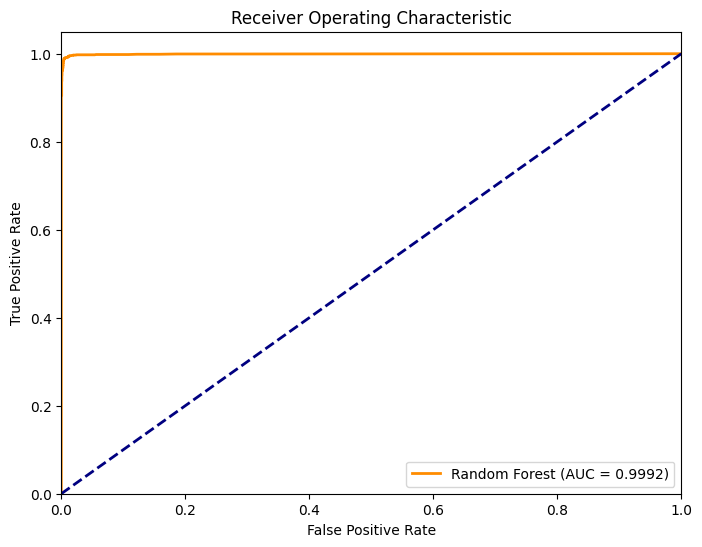


Bagging Classifier Performance:
Testing Accuracy: 0.9945
Testing AUC: 0.9983
Testing AUC-PR: 0.9973
Testing Precision: 0.9891
Testing Recall: 0.9945
Testing Specificity: 0.0056
Testing F1-score: 0.9918
ROC Curve of Test Set


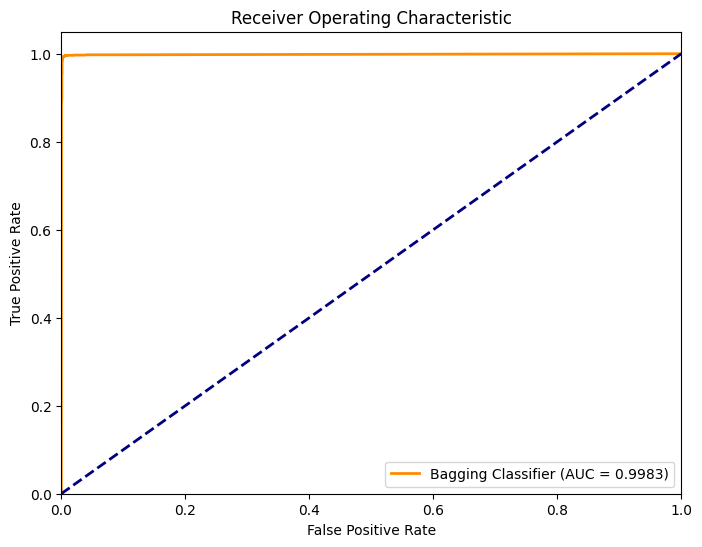

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:49:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Performance:
Testing Accuracy: 0.9949
Testing AUC: 0.9988
Testing AUC-PR: 0.9986
Testing Precision: 0.9915
Testing Recall: 0.9933
Testing Specificity: 0.0043
Testing F1-score: 0.9924
ROC Curve of Test Set


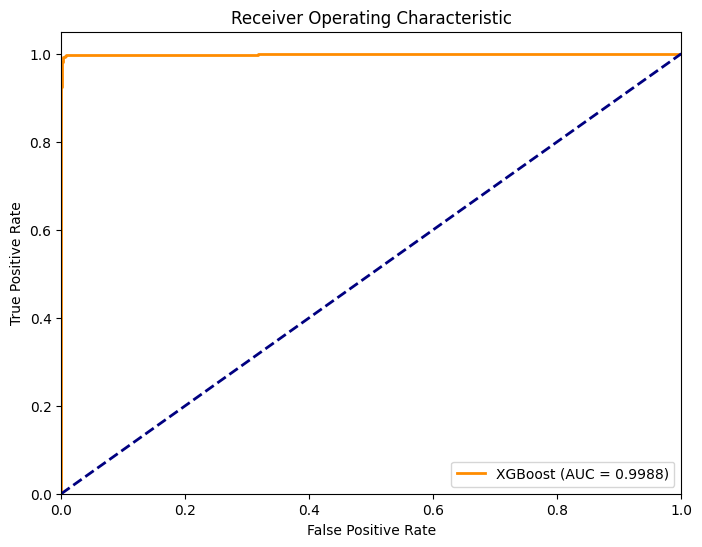


Best Model: Random Forest with Testing AUC-PR = 0.9988


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier  # Import XGBoost

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=300),
    "Bagging Classifier": BaggingClassifier(random_state=42, n_estimators=300),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, n_estimators=300)  # XGBoost added
}

best_model_name = None
best_auc_pr = 0

# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test_proba = model.predict_proba(X_test)[:, 1]  # Get probability scores
    y_pred_test = (y_pred_test_proba >= 0.5).astype(int)  # Apply threshold

    # Training performance
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_auc_pr = average_precision_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = 1 - recall_score(y_train, y_pred_train, pos_label=0)
    train_f1 = f1_score(y_train, y_pred_train)

    # Testing performance
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test_proba)  # Use probabilities for AUC
    test_auc_pr = average_precision_score(y_test, y_pred_test_proba)  # Use probabilities for AUC-PR
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = 1 - recall_score(y_test, y_pred_test, pos_label=0)
    test_f1 = f1_score(y_test, y_pred_test)

    print(f"\n{model_name} Performance:")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(f"Testing AUC: {test_auc:.4f}")
    print(f"Testing AUC-PR: {test_auc_pr:.4f}")
    print(f"Testing Precision: {test_precision:.4f}")
    print(f"Testing Recall: {test_recall:.4f}")
    print(f"Testing Specificity: {test_specificity:.4f}")
    print(f"Testing F1-score: {test_f1:.4f}")

    # Plot ROC curve
    print('ROC Curve of Test Set')
    fpr, tpr, _ = roc_curve(y_test, y_pred_test_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {test_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Update best model
    if test_auc_pr > best_auc_pr:
        best_auc_pr = test_auc_pr
        best_model_name = model_name

print(f"\nBest Model: {best_model_name} with Testing AUC-PR = {best_auc_pr:.4f}")


## 2.3 Scoring the Best Model on the Validation Dataset 

* Validation dataset  has never been used in the model training process).
* This dataset contains less than 1% fraud rate


Best Model Performance on Validation Set:
Accuracy: 0.9928
AUC: 0.9997
AUC-PR: 0.5840
Precision: 0.0018
Recall: 0.9878
Specificity: 0.0072
F1-score: 0.0035


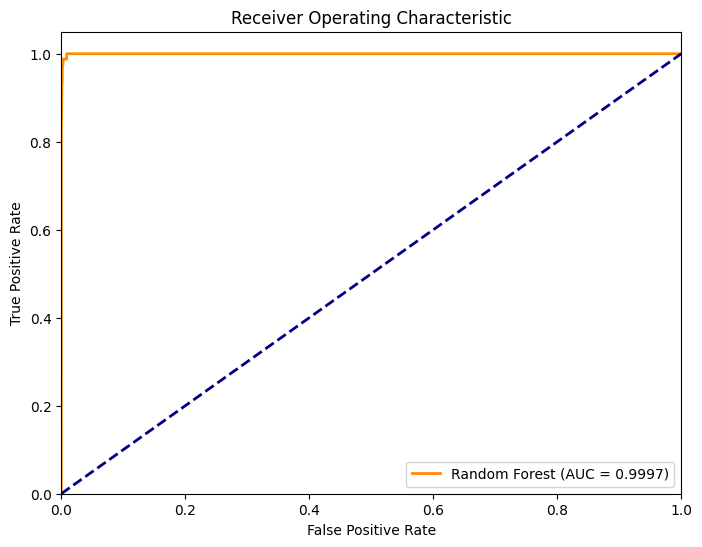

In [ ]:
from sklearn.metrics import precision_recall_curve
# Get the best model
best_model = models[best_model_name]

# Make predictions on the validation set
y_pred_val = best_model.predict(df_modeling_val.drop("isFraud", axis=1))
y_pred_val_proba = best_model.predict_proba(df_modeling_val.drop("isFraud", axis=1))[:, 1]

# Evaluate the best model on the validation set
val_accuracy = accuracy_score(df_modeling_val["isFraud"], y_pred_val)
val_auc = roc_auc_score(df_modeling_val["isFraud"], y_pred_val_proba)
val_auc_pr = average_precision_score(df_modeling_val["isFraud"], y_pred_val_proba)
val_precision = precision_score(df_modeling_val["isFraud"], y_pred_val)
val_recall = recall_score(df_modeling_val["isFraud"], y_pred_val)
val_specificity = 1 - recall_score(df_modeling_val["isFraud"], y_pred_val, pos_label=0)
val_f1 = f1_score(df_modeling_val["isFraud"], y_pred_val)

print("\nBest Model Performance on Validation Set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"AUC: {val_auc:.4f}")
print(f"AUC-PR: {val_auc_pr:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"Specificity: {val_specificity:.4f}")
print(f"F1-score: {val_f1:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(df_modeling_val["isFraud"], y_pred_val_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{best_model_name} (AUC = {val_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot AUC-PR curve
#precision, recall, _ = precision_recall_curve(df_modeling_val["isFraud"], y_pred_val_proba)
#plt.figure(figsize=(8, 6))
#plt.plot(recall, precision, color='darkorange', lw=2, label=f'{best_model_name} (AUC-PR = {val_auc_pr:.4f})')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.title('Precision-Recall Curve')
#plt.legend(loc="lower left")
#plt.show()

* **The model did not perform well on the validation dataset.**
* This is because of the low **Area Under the Precision-Recall Curve (AUC-PR)** score, which summarizes the performance of the model over all possible thresholds (particularly useful to evaluate a classifier on an imbalanced dataset)

**Best Model (Random Forest) Performance on Validation Set:**

* Accuracy: 0.9928
* AUC: 0.9997
* AUC-PR: 0.5840
* Precision: 0.0018
* Recall: 0.9878
* Specificity: 0.0072
* F1-score: 0.0035

<br>

# 3. Resampling Method 2: Using SMOTE to Oversample Fraud Observations

SMOTE (Synthetic Minority Oversampling Technique) is a data augmentation technique used to address class imbalance in datasets by creating synthetic samples of the minority class, improving model performance and reducing overfitting.

## 3.1 SMOTE and Modeling with Oversampled Data

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Performance:

Training Accuracy: 0.9066
Training AUC: 0.9066
Training AUC-PR: 0.8716
Training Precision: 0.9138
Training Recall: 0.8980
Training Specificity: 0.0847
Training F1-score: 0.9058


Testing Accuracy: 0.9066
Testing AUC: 0.9066
Testing AUC-PR: 0.8716
Testing Precision: 0.9137
Testing Recall: 0.8981
Testing Specificity: 0.0848
Testing F1-score: 0.9058
ROC Curve of Test Set


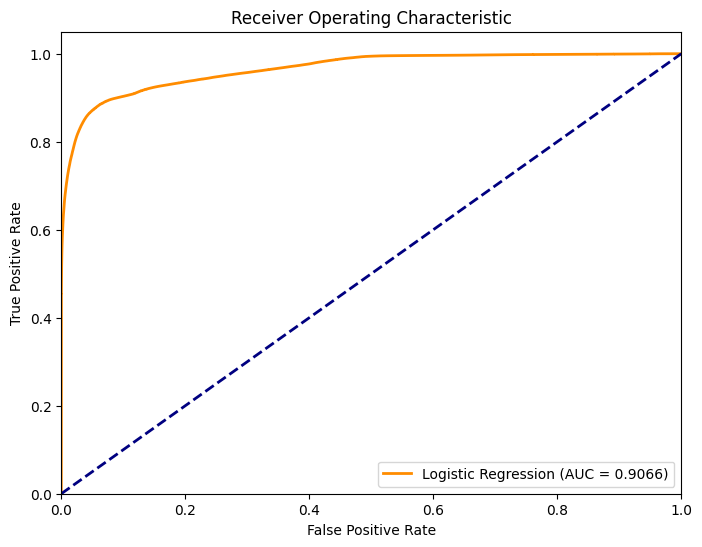


Gradient Boosting Performance:

Training Accuracy: 0.9910
Training AUC: 0.9910
Training AUC-PR: 0.9846
Training Precision: 0.9869
Training Recall: 0.9952
Training Specificity: 0.0132
Training F1-score: 0.9910


Testing Accuracy: 0.9911
Testing AUC: 0.9911
Testing AUC-PR: 0.9847
Testing Precision: 0.9870
Testing Recall: 0.9953
Testing Specificity: 0.0131
Testing F1-score: 0.9911
ROC Curve of Test Set


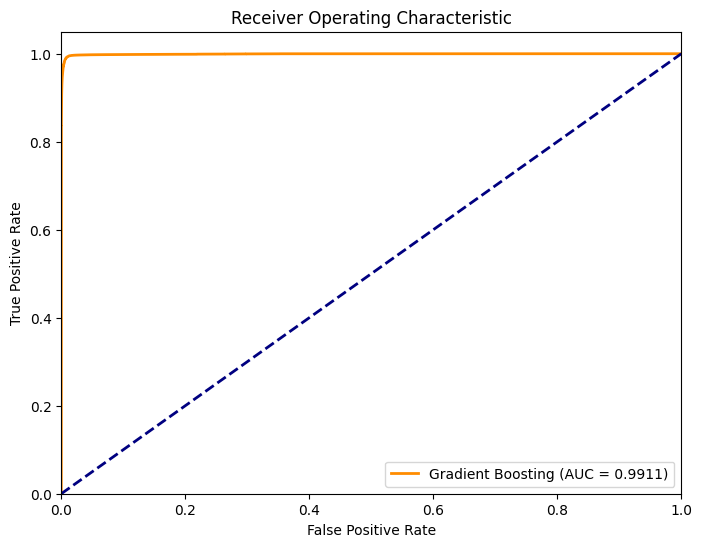


Decision Tree Performance:

Training Accuracy: 1.0000
Training AUC: 1.0000
Training AUC-PR: 1.0000
Training Precision: 1.0000
Training Recall: 1.0000
Training Specificity: 0.0000
Training F1-score: 1.0000


Testing Accuracy: 0.9996
Testing AUC: 0.9996
Testing AUC-PR: 0.9993
Testing Precision: 0.9994
Testing Recall: 0.9999
Testing Specificity: 0.0006
Testing F1-score: 0.9996
ROC Curve of Test Set


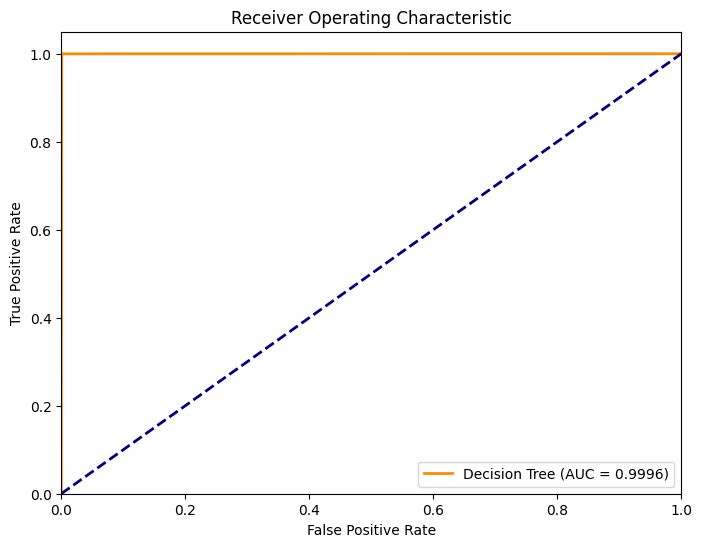


Random Forest Performance:

Training Accuracy: 1.0000
Training AUC: 1.0000
Training AUC-PR: 1.0000
Training Precision: 1.0000
Training Recall: 1.0000
Training Specificity: 0.0000
Training F1-score: 1.0000


Testing Accuracy: 0.9998
Testing AUC: 0.9998
Testing AUC-PR: 0.9996
Testing Precision: 0.9996
Testing Recall: 1.0000
Testing Specificity: 0.0004
Testing F1-score: 0.9998
ROC Curve of Test Set


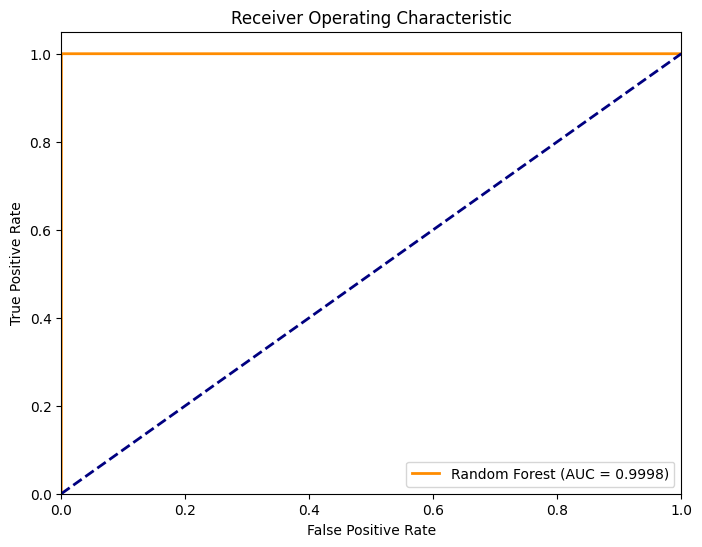

In [ ]:
from imblearn.over_sampling import SMOTE

# Separate the features and target
X = df_modeling_encoded.drop("isFraud", axis=1)
y = df_modeling_encoded["isFraud"]

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and transform the data
X_res, y_res = smote.fit_resample(X, y)

# Apply StandardScaler to the features (optional)
#scaler = StandardScaler()
#X_res_scaled = scaler.fit_transform(X_res)


X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=200),
    "Bagging Classifier": BaggingClassifier(random_state=42, n_estimators=200)
}


best_model_name = None
best_auc_pr = 0

# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_test_proba = model.predict_proba(X_test)[:, 1]

    # Training performance
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_auc_pr = average_precision_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = 1 - recall_score(y_train, y_pred_train, pos_label=0)
    train_f1 = f1_score(y_train, y_pred_train)

    # Testing performance
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_auc_pr = average_precision_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = 1 - recall_score(y_test, y_pred_test, pos_label=0)
    test_f1 = f1_score(y_test, y_pred_test)

    print(f"\n{model_name} Performance:")
    print('')
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Training AUC: {train_auc:.4f}")
    print(f"Training AUC-PR: {train_auc_pr:.4f}")
    print(f"Training Precision: {train_precision:.4f}")
    print(f"Training Recall: {train_recall:.4f}")
    print(f"Training Specificity: {train_specificity:.4f}")
    print(f"Training F1-score: {train_f1:.4f}")
    print('')
    print('')

    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(f"Testing AUC: {test_auc:.4f}")
    print(f"Testing AUC-PR: {test_auc_pr:.4f}")
    print(f"Testing Precision: {test_precision:.4f}")
    print(f"Testing Recall: {test_recall:.4f}")
    print(f"Testing Specificity: {test_specificity:.4f}")
    print(f"Testing F1-score: {test_f1:.4f}")

    # Plot ROC curve

    print('ROC Curve of Test Set')
    fpr, tpr, _ = roc_curve(y_test, y_pred_test_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {test_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()



# Update best model
    if test_auc_pr > best_auc_pr:
        best_auc_pr = test_auc_pr
        best_model_name = model_name

print(f"\nBest Model: {best_model_name} with Testing AUC-PR = {best_auc_pr:.4f}")

## 3.2 Scoring the Best Model on the Validation Dataset 

* The validation dataset has never been used in the model training process).
* This dataset contains less than 1% fraud rate

In [ ]:
from sklearn.metrics import precision_recall_curve
# Get the best model
best_model = models[best_model_name]

# Make predictions on the validation set
y_pred_val = best_model.predict(df_modeling_val.drop("isFraud", axis=1))
y_pred_val_proba = best_model.predict_proba(df_modeling_val.drop("isFraud", axis=1))[:, 1]

# Evaluate the best model on the validation set
val_accuracy = accuracy_score(df_modeling_val["isFraud"], y_pred_val)
val_auc = roc_auc_score(df_modeling_val["isFraud"], y_pred_val_proba)
val_auc_pr = average_precision_score(df_modeling_val["isFraud"], y_pred_val_proba)
val_precision = precision_score(df_modeling_val["isFraud"], y_pred_val)
val_recall = recall_score(df_modeling_val["isFraud"], y_pred_val)
val_specificity = 1 - recall_score(df_modeling_val["isFraud"], y_pred_val, pos_label=0)
val_f1 = f1_score(df_modeling_val["isFraud"], y_pred_val)

print("\nBest Model Performance on Validation Set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"AUC: {val_auc:.4f}")
print(f"AUC-PR: {val_auc_pr:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"Specificity: {val_specificity:.4f}")
print(f"F1-score: {val_f1:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(df_modeling_val["isFraud"], y_pred_val_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{best_model_name} (AUC = {val_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot AUC-PR curve
#precision, recall, _ = precision_recall_curve(df_modeling_val["isFraud"], y_pred_val_proba)
#plt.figure(figsize=(8, 6))
#plt.plot(recall, precision, color='darkorange', lw=2, label=f'{best_model_name} (AUC-PR = {val_auc_pr:.4f})')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.title('Precision-Recall Curve')
#plt.legend(loc="lower left")
#plt.show()

**Best Model Performance on Validation Set:**

* Accuracy: 0.9928
* AUC: 0.9997
* AUC-PR: 0.5840
* Precision: 0.0018
* Recall: 0.9878
* Specificity: 0.0072
* F1-score: 0.0035

## 3.3 Fitting XGBoost Model on the Oversampled Data

In [ ]:
from xgboost import XGBClassifier
# Initialize XGBoost model with hyperparameters
tuned_xgb = XGBClassifier(
    scale_pos_weight=10,  # Balances the class distribution
    n_estimators=200,  # Number of trees
    max_depth=6,  # Limits overfitting
    learning_rate=0.05,  # Adjusts model updates
    eval_metric="logloss",  # Suitable for binary classification
    use_label_encoder=False,  # Suppresses warning
    random_state=42
)

# Train the model
tuned_xgb.fit(X_train, y_train)

# Make predictions
y_pred_train = tuned_xgb.predict(X_train)
y_pred_test = tuned_xgb.predict(X_test)
y_pred_test_proba = tuned_xgb.predict_proba(X_test)[:, 1]

# Compute Training Metrics
train_accuracy = accuracy_score(y_train, y_pred_train)
train_auc = roc_auc_score(y_train, tuned_xgb.predict_proba(X_train)[:, 1])
train_auc_pr = average_precision_score(y_train, tuned_xgb.predict_proba(X_train)[:, 1])
train_precision = precision_score(y_train, y_pred_train)
train_recall = recall_score(y_train, y_pred_train)
train_specificity = 1 - recall_score(y_train, y_pred_train, pos_label=0)
train_f1 = f1_score(y_train, y_pred_train)

# Compute Testing Metrics
test_accuracy = accuracy_score(y_test, y_pred_test)
test_auc = roc_auc_score(y_test, y_pred_test_proba)
test_auc_pr = average_precision_score(y_test, y_pred_test_proba)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_specificity = 1 - recall_score(y_test, y_pred_test, pos_label=0)
test_f1 = f1_score(y_test, y_pred_test)

print("XGBoost Model Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training AUC: {train_auc:.4f}")
print(f"Training AUC-PR: {train_auc_pr:.4f}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Training Specificity: {train_specificity:.4f}")
print(f"Training F1-score: {train_f1:.4f}\n")

print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Testing AUC: {test_auc:.4f}")
print(f"Testing AUC-PR: {test_auc_pr:.4f}")
print(f"Testing Precision: {test_precision:.4f}")
print(f"Testing Recall: {test_recall:.4f}")
print(f"Testing Specificity: {test_specificity:.4f}")
print(f"Testing F1-score: {test_f1:.4f}\n")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'XGBoost (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 3.4 Scoring the XGBoost Model on the Validation Data Set

In [ ]:
# Assuming df_modeling_encoded and df_modeling_val are your preprocessed datasets
X = df_modeling_encoded.drop("isFraud", axis=1)
y = df_modeling_encoded["isFraud"]
X_val = df_modeling_val.drop("isFraud", axis=1)
y_val = df_modeling_val["isFraud"]

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost model with hyperparameters
tuned_xgb = XGBClassifier(
    scale_pos_weight=5,  # Adjusted to balance fraud vs. non-fraud
    n_estimators=400,  # Increased tree count for better learning
    max_depth=5,  # Reduced to prevent overfitting
    learning_rate=0.03,  # Lowered for better generalization
    subsample=0.8,  # Randomly selects 80% of data per tree
    colsample_bytree=0.8,  # Uses 80% of features per tree
    gamma=5,  # Higher value to prevent unnecessary splits
    min_child_weight=5,  # Increases robustness of splits
    eval_metric="logloss",  # Best for fraud classification
    use_label_encoder=False,  # Suppresses warning
    random_state=42
)

# Train the model
tuned_xgb.fit(X_train, y_train)

# Make predictions
y_pred_val = tuned_xgb.predict(X_val)
y_pred_val_proba = tuned_xgb.predict_proba(X_val)[:, 1]

# Compute Validation Metrics
val_accuracy = accuracy_score(y_val, y_pred_val)
val_auc = roc_auc_score(y_val, y_pred_val_proba)
val_auc_pr = average_precision_score(y_val, y_pred_val_proba)
val_precision = precision_score(y_val, y_pred_val)
val_recall = recall_score(y_val, y_pred_val)
val_specificity = 1 - recall_score(y_val, y_pred_val, pos_label=0)
val_f1 = f1_score(y_val, y_pred_val)

print("XGBoost Model Performance on Validation Set:")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation AUC: {val_auc:.4f}")
print(f"Validation AUC-PR: {val_auc_pr:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation Specificity: {val_specificity:.4f}")
print(f"Validation F1-score: {val_f1:.4f}\n")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_pred_val_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'XGBoost (AUC = {val_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**XGBoost Model Performance on Validation Set:**

* Validation Accuracy: 0.9999
* Validation AUC: 0.9999
* Validation AUC-PR: 0.8076
* Validation Precision: 0.1141
* Validation Recall: 0.8902
* Validation Specificity: 0.0001
* Validation F1-score: 0.2022

<br>

# 4. Resampling Method 3: Remodel using the Imbalanced Dataset

* Perform model development without undersampling or oversampling, but here we use class weights=='balanced'

## 4.1 Modeling with Imbalanced Data and Balanced Class Weights

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Performance:

Training Accuracy: 0.9602
Training AUC: 0.9137
Training AUC-PR: 0.0241
Training Precision: 0.0276
Training Recall: 0.8670
Training Specificity: 0.0397
Training F1-score: 0.0534

Testing Accuracy: 0.9605
Testing AUC: 0.9115
Testing AUC-PR: 0.0236
Testing Precision: 0.0272
Testing Recall: 0.8623
Testing Specificity: 0.0394
Testing F1-score: 0.0527
ROC Curve of Test Set


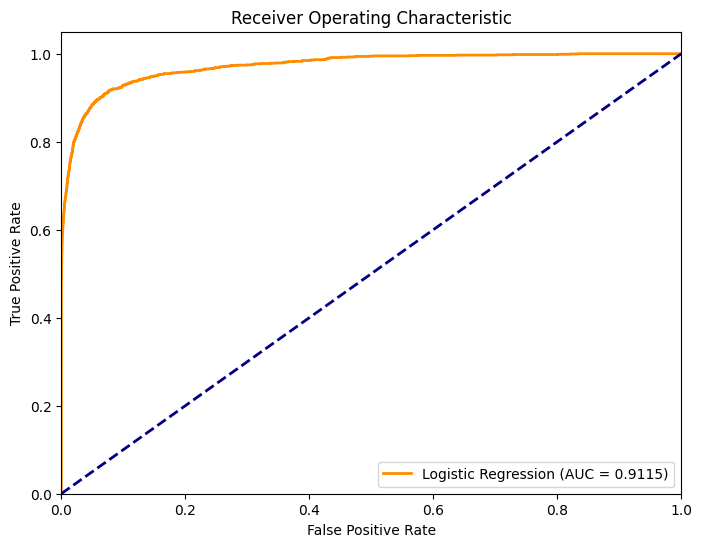


Gradient Boosting Performance:

Training Accuracy: 0.9989
Training AUC: 0.6183
Training AUC-PR: 0.1912
Training Precision: 0.8037
Training Recall: 0.2366
Training Specificity: 0.0001
Training F1-score: 0.3656

Testing Accuracy: 0.9990
Testing AUC: 0.6277
Testing AUC-PR: 0.2056
Testing Precision: 0.8008
Testing Recall: 0.2556
Testing Specificity: 0.0001
Testing F1-score: 0.3875
ROC Curve of Test Set


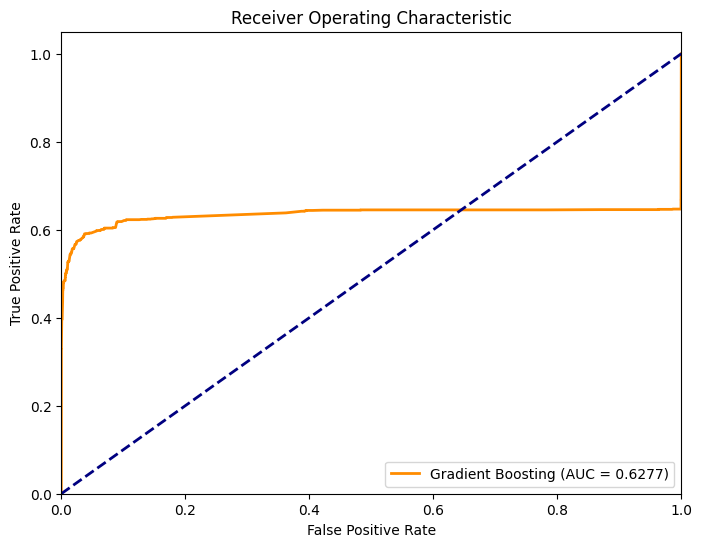


Decision Tree Performance:

Training Accuracy: 1.0000
Training AUC: 1.0000
Training AUC-PR: 1.0000
Training Precision: 1.0000
Training Recall: 1.0000
Training Specificity: 0.0000
Training F1-score: 1.0000

Testing Accuracy: 0.9997
Testing AUC: 0.9311
Testing AUC-PR: 0.7769
Testing Precision: 0.9007
Testing Recall: 0.8623
Testing Specificity: 0.0001
Testing F1-score: 0.8811
ROC Curve of Test Set


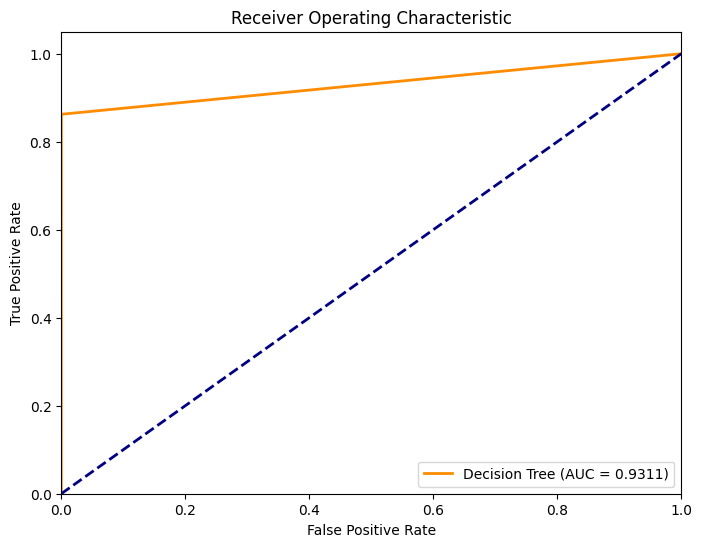


Random Forest Performance:

Training Accuracy: 1.0000
Training AUC: 1.0000
Training AUC-PR: 1.0000
Training Precision: 1.0000
Training Recall: 1.0000
Training Specificity: 0.0000
Training F1-score: 1.0000

Testing Accuracy: 0.9997
Testing AUC: 0.9028
Testing AUC-PR: 0.8003
Testing Precision: 0.9932
Testing Recall: 0.8056
Testing Specificity: 0.0000
Testing F1-score: 0.8896
ROC Curve of Test Set


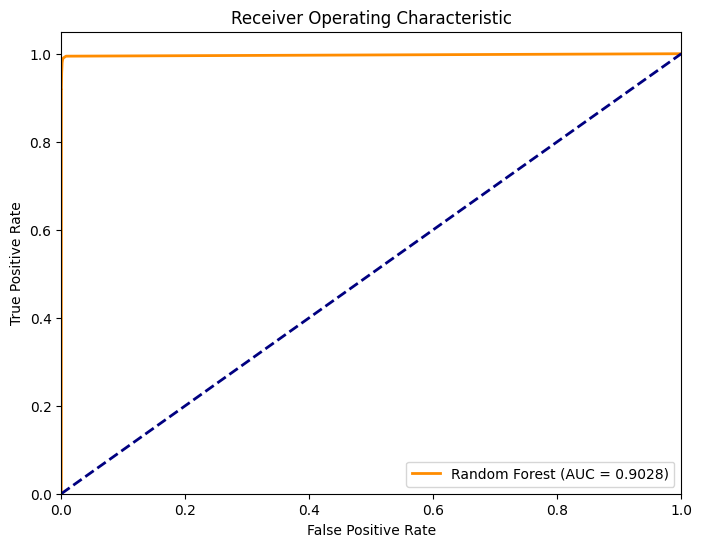

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve
)

# Create train and test set: Split df_modeling_balanced into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df_modeling_encoded.drop('isFraud', axis=1), df_modeling_encoded['isFraud'], test_size=0.2, random_state=42
)

# Compute `scale_pos_weight` for XGBoost (handling class imbalance)
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Initialize models with class_weight='balanced' where applicable
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(),  # No class_weight
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=200, class_weight='balanced'),
    "Bagging Classifier": BaggingClassifier(random_state=42, n_estimators=200),  # No class_weight
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale_pos_weight)  # Handles imbalance
}

best_model_name = None
best_auc_pr = 0

# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Training performance
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_auc_pr = average_precision_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = 1 - recall_score(y_train, y_pred_train, pos_label=0)
    train_f1 = f1_score(y_train, y_pred_train)

    # Testing performance
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_auc_pr = average_precision_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = 1 - recall_score(y_test, y_pred_test, pos_label=0)
    test_f1 = f1_score(y_test, y_pred_test)

    print(f"\n{model_name} Performance:\n")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Training AUC: {train_auc:.4f}")
    print(f"Training AUC-PR: {train_auc_pr:.4f}")
    print(f"Training Precision: {train_precision:.4f}")
    print(f"Training Recall: {train_recall:.4f}")
    print(f"Training Specificity: {train_specificity:.4f}")
    print(f"Training F1-score: {train_f1:.4f}\n")

    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(f"Testing AUC: {test_auc:.4f}")
    print(f"Testing AUC-PR: {test_auc_pr:.4f}")
    print(f"Testing Precision: {test_precision:.4f}")
    print(f"Testing Recall: {test_recall:.4f}")
    print(f"Testing Specificity: {test_specificity:.4f}")
    print(f"Testing F1-score: {test_f1:.4f}")

    # Plot ROC curve only if the model supports probability predictions
    if y_pred_test_proba is not None:
        print('ROC Curve of Test Set')
        fpr, tpr, _ = roc_curve(y_test, y_pred_test_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {test_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    # Update best model
    if test_auc_pr > best_auc_pr:
        best_auc_pr = test_auc_pr
        best_model_name = model_name

print(f"\nBest Model: {best_model_name} with Testing AUC-PR = {best_auc_pr:.4f}")


**XGBoost Performance - Training:**

* Training Accuracy: 0.9981
* Training AUC: 0.9990
* Training AUC-PR: 0.4040
* Training Precision: 0.4040
* Training Recall: 1.0000
* Training Specificity: 0.0019
* Training F1-score: 0.5755

**XGBoost Performance - Testing:**

* Testing Accuracy: 0.9979
* Testing AUC: 0.9925
* Testing AUC-PR: 0.3751
* Testing Precision: 0.3800
* Testing Recall: 0.9870
* Testing Specificity: 0.0021
* Testing F1-score: 0.5487

## 4.2 Scoring the Best Model on the Validation Dataset 

In [ ]:
from sklearn.metrics import precision_recall_curve
# Get the best model
best_model = models[best_model_name]

# Make predictions on the validation set
y_pred_val = best_model.predict(df_modeling_val.drop("isFraud", axis=1))
y_pred_val_proba = best_model.predict_proba(df_modeling_val.drop("isFraud", axis=1))[:, 1]

# Evaluate the best model on the validation set
val_accuracy = accuracy_score(df_modeling_val["isFraud"], y_pred_val)
val_auc = roc_auc_score(df_modeling_val["isFraud"], y_pred_val_proba)
val_auc_pr = average_precision_score(df_modeling_val["isFraud"], y_pred_val_proba)
val_precision = precision_score(df_modeling_val["isFraud"], y_pred_val)
val_recall = recall_score(df_modeling_val["isFraud"], y_pred_val)
val_specificity = 1 - recall_score(df_modeling_val["isFraud"], y_pred_val, pos_label=0)
val_f1 = f1_score(df_modeling_val["isFraud"], y_pred_val)

print("\nBest Model Performance on Validation Set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"AUC: {val_auc:.4f}")
print(f"AUC-PR: {val_auc_pr:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"Specificity: {val_specificity:.4f}")
print(f"F1-score: {val_f1:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(df_modeling_val["isFraud"], y_pred_val_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{best_model_name} (AUC = {val_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Best Model (XGBoost) Performance on Validation Set:

Accuracy: 0.9981

AUC: 0.9999

AUC-PR: 0.0647

Precision: 0.0066

Recall: 1.0000

Specificity: 0.0019

F1-score: 0.0132

## 4.3 Redo the Model using the Raw Imbalanced Dataset without Balanced Class Weights

In [ ]:
# Create train and test set: Split df_modeling_balanced into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_modeling.drop('isFraud', axis=1), df_modeling['isFraud'], test_size=0.2, random_state=42)


# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=200),
    "Bagging Classifier": BaggingClassifier(random_state=42, n_estimators=200)
}


best_model_name = None
best_auc_pr = 0

# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_test_proba = model.predict_proba(X_test)[:, 1]

    # Training performance
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_auc_pr = average_precision_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = 1 - recall_score(y_train, y_pred_train, pos_label=0)
    train_f1 = f1_score(y_train, y_pred_train)

    # Testing performance
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_auc_pr = average_precision_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = 1 - recall_score(y_test, y_pred_test, pos_label=0)
    test_f1 = f1_score(y_test, y_pred_test)

    print(f"\n{model_name} Performance:")
    print('')
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Training AUC: {train_auc:.4f}")
    print(f"Training AUC-PR: {train_auc_pr:.4f}")
    print(f"Training Precision: {train_precision:.4f}")
    print(f"Training Recall: {train_recall:.4f}")
    print(f"Training Specificity: {train_specificity:.4f}")
    print(f"Training F1-score: {train_f1:.4f}")
    print('')
    print('')

    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(f"Testing AUC: {test_auc:.4f}")
    print(f"Testing AUC-PR: {test_auc_pr:.4f}")
    print(f"Testing Precision: {test_precision:.4f}")
    print(f"Testing Recall: {test_recall:.4f}")
    print(f"Testing Specificity: {test_specificity:.4f}")
    print(f"Testing F1-score: {test_f1:.4f}")

    # Plot ROC curve

    print('ROC Curve of Test Set')
    fpr, tpr, _ = roc_curve(y_test, y_pred_test_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {test_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()



# Update best model
    if test_auc_pr > best_auc_pr:
        best_auc_pr = test_auc_pr
        best_model_name = model_name

print(f"\nBest Model: {best_model_name} with Testing AUC-PR = {best_auc_pr:.4f}")

## 4.4 Score the Best Model on the Validation Dataset 

* Validation dataset has never been used in the model training process.
* This dataset contains less than 1% fraud rate

In [ ]:
from sklearn.metrics import precision_recall_curve
# Get the best model
best_model = models[best_model_name]

# Make predictions on the validation set
y_pred_val = best_model.predict(df_modeling_val.drop("isFraud", axis=1))
y_pred_val_proba = best_model.predict_proba(df_modeling_val.drop("isFraud", axis=1))[:, 1]

# Evaluate the best model on the validation set
val_accuracy = accuracy_score(df_modeling_val["isFraud"], y_pred_val)
val_auc = roc_auc_score(df_modeling_val["isFraud"], y_pred_val_proba)
val_auc_pr = average_precision_score(df_modeling_val["isFraud"], y_pred_val_proba)
val_precision = precision_score(df_modeling_val["isFraud"], y_pred_val)
val_recall = recall_score(df_modeling_val["isFraud"], y_pred_val)
val_specificity = 1 - recall_score(df_modeling_val["isFraud"], y_pred_val, pos_label=0)
val_f1 = f1_score(df_modeling_val["isFraud"], y_pred_val)

print("\nBest Model Performance on Validation Set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"AUC: {val_auc:.4f}")
print(f"AUC-PR: {val_auc_pr:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"Specificity: {val_specificity:.4f}")
print(f"F1-score: {val_f1:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(df_modeling_val["isFraud"], y_pred_val_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{best_model_name} (AUC = {val_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot AUC-PR curve
#precision, recall, _ = precision_recall_curve(df_modeling_val["isFraud"], y_pred_val_proba)
#plt.figure(figsize=(8, 6))
#plt.plot(recall, precision, color='darkorange', lw=2, label=f'{best_model_name} (AUC-PR = {val_auc_pr:.4f})')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.title('Precision-Recall Curve')
#plt.legend(loc="lower left")
#plt.show()

## 4.5 Using Hyperparameters with the Aforementioned Models 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Initialize models and hyperparameter grids
models = {
    "Logistic Regression": {
        "model": LogisticRegression(),
        "params": {
            "penalty": ["l2"],
            "C": [0.1, 1, 10],
            "max_iter": [1000, 2000, 5000]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(),
        "params": {
            "learning_rate": [0.01, 0.1, 1],
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 5, 10]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "criterion": ["gini", "entropy"],
            "max_depth": [3, 5, 10],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 5, 10],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Bagging Classifier": {
        "model": BaggingClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_samples": [0.5, 1],
            "max_features": [0.5, 1]
        }
    }
}

best_model_name = None
best_auc_pr = 0

# Train and evaluate models with hyperparameter tuning
for model_name, model_info in models.items():
    # replacing with random search might make tuning faster (keeping variable name for easy switch)
    grid_search = RandomizedSearchCV(model_info["model"], model_info["params"], cv=5, scoring="average_precision")
    grid_search.fit(X_train, y_train)

    print(f"\n{model_name} Best Parameters: {grid_search.best_params_}")

    y_pred_train = grid_search.best_estimator_.predict(X_train)
    y_pred_test = grid_search.best_estimator_.predict(X_test)
    y_pred_test_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

    # Training performance
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_auc_pr = average_precision_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = 1 - recall_score(y_train, y_pred_train, pos_label=0)
    train_f1 = f1_score(y_train, y_pred_train)

    # Testing performance
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_auc_pr = average_precision_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = 1 - recall_score(y_test, y_pred_test, pos_label=0)
    test_f1 = f1_score(y_test, y_pred_test)

    print(f"\n{model_name} Performance:")
    print('')
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Training AUC: {train_auc:.4f}")
    print(f"Training AUC-PR: {train_auc_pr:.4f}")
    print(f"Training Precision: {train_precision:.4f}")
    print(f"Training Recall: {train_recall:.4f}")
    print(f"Training Specificity: {train_specificity:.4f}")
    print(f"Training F1-score: {train_f1:.4f}")
    print('')
    print('')

    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(f"Testing AUC: {test_auc:.4f}")
    print(f"Testing AUC-PR: {test_auc_pr:.4f}")
    print(f"Testing Precision: {test_precision:.4f}")
    print(f"Testing Recall: {test_recall:.4f}")
    print(f"Testing Specificity: {test_specificity:.4f}")
    print(f"Testing F1-score: {test_f1:.4f}")

    # Plot ROC curve

    print('ROC Curve of Test Set')
    fpr, tpr, _ = roc_curve(y_test, y_pred_test_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {test_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Update best model
    if test_auc_pr > best_auc_pr:
        best_auc_pr = test_auc_pr
        best_model_name = model_name

print(f"\nBest Model: {best_model_name} with Testing AUC-PR = {best_auc_pr:.4f}")

<br>

# 5. Anomaly Detection Models

Testing anomaly detection becuase the fraud rate in the data is less than 1%.

## 5.1 SVM and Autoencoders

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler

# Simulating df_modeling_encoded dataset for demonstration
np.random.seed(42)
n_samples = 1000
n_features = 10

# Generate synthetic dataset with some anomalies
X = np.random.rand(n_samples, n_features)
y = np.random.choice([0, 1], size=n_samples, p=[0.95, 0.05])  # Simulating rare fraud cases

df_modeling_encoded = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(n_features)])
df_modeling_encoded['isFraud'] = y

# Standardize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_modeling_encoded.drop("isFraud", axis=1))

# --------------- One-Class SVM ---------------
ocsvm_model = OneClassSVM(kernel="rbf", nu=0.01, gamma="scale")
ocsvm_model.fit(X_scaled)

# Predict anomalies
ocsvm_scores = ocsvm_model.decision_function(X_scaled)
ocsvm_predictions = ocsvm_model.predict(X_scaled)
ocsvm_predictions = np.where(ocsvm_predictions == -1, 1, 0)  # Convert -1 (anomaly) to 1 (fraud)

# Compute specificity for One-Class SVM
tn, fp, fn, tp = confusion_matrix(df_modeling_encoded['isFraud'], ocsvm_predictions).ravel()
ocsvm_specificity = tn / (tn + fp)

# Evaluate One-Class SVM
ocsvm_auc = roc_auc_score(df_modeling_encoded['isFraud'], ocsvm_scores)
ocsvm_auc_pr = average_precision_score(df_modeling_encoded['isFraud'], ocsvm_scores)
ocsvm_precision = precision_score(df_modeling_encoded['isFraud'], ocsvm_predictions)
ocsvm_recall = recall_score(df_modeling_encoded['isFraud'], ocsvm_predictions)
ocsvm_f1 = f1_score(df_modeling_encoded['isFraud'], ocsvm_predictions)

# --------------- Autoencoder ---------------
input_dim = X_scaled.shape[1]
encoding_dim = 5  # Compressed representation size

# Define autoencoder model
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation="relu")(input_layer)
decoded = Dense(input_dim, activation="sigmoid")(encoded)
autoencoder = keras.Model(input_layer, decoded)

# Compile and train
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.fit(X_scaled, X_scaled, epochs=20, batch_size=32, shuffle=True, verbose=0)

# Compute reconstruction error
reconstructions = autoencoder.predict(X_scaled)
reconstruction_errors = np.mean((X_scaled - reconstructions) ** 2, axis=1)

# Determine threshold for anomalies (e.g., top 1% highest errors)
threshold = np.percentile(reconstruction_errors, 99)
autoencoder_predictions = (reconstruction_errors > threshold).astype(int)

# Compute specificity for Autoencoder
tn, fp, fn, tp = confusion_matrix(df_modeling_encoded['isFraud'], autoencoder_predictions).ravel()
autoencoder_specificity = tn / (tn + fp)

# Evaluate Autoencoder
autoencoder_auc = roc_auc_score(df_modeling_encoded['isFraud'], reconstruction_errors)
autoencoder_auc_pr = average_precision_score(df_modeling_encoded['isFraud'], reconstruction_errors)
autoencoder_precision = precision_score(df_modeling_encoded['isFraud'], autoencoder_predictions)
autoencoder_recall = recall_score(df_modeling_encoded['isFraud'], autoencoder_predictions)
autoencoder_f1 = f1_score(df_modeling_encoded['isFraud'], autoencoder_predictions)

# Store results
results = pd.DataFrame({
    "Model": ["One-Class SVM", "Autoencoder"],
    "AUC": [ocsvm_auc, autoencoder_auc],
    "AUC-PR": [ocsvm_auc_pr, autoencoder_auc_pr],
    "Precision": [ocsvm_precision, autoencoder_precision],
    "Recall": [ocsvm_recall, autoencoder_recall],
    "Specificity": [ocsvm_specificity, autoencoder_specificity],
    "F1-Score": [ocsvm_f1, autoencoder_f1]
})

# Display results
#import ace_tools as tools
#tools.display_dataframe_to_user(name="Anomaly Detection Model Performance", dataframe=results)
results

Model	                AUC	AUC-PR	Precision	Recall	Specificity	F1-Score



0	One-Class SVM	0.478162	0.051162	0.085106	0.088889	0.954974	0.086957



1	Autoencoder	0.484677	0.046438	0.100000	0.022222	0.990576	0.036364

## 5.2 Isolation Forest Algorithm

* Isolation Forest algorithm works by isolating anomalies instead of profiling normal data.
* Isolation Forest is particularly effective for high-dimensional data

In [ ]:
#Isolation Forest algorithm works by isolating anomalies instead of profiling normal data.
# Isolation Forest is particularly effective for high-dimensional data

from sklearn.ensemble import IsolationForest

# Initialize Isolation Forest model
if_model = IsolationForest(contamination=0.01, random_state=42)

# Fit the model to the data
if_model.fit(df_modeling_encoded.drop('isFraud', axis=1))

# Predict anomalies
anomaly_scores = if_model.decision_function(df_modeling_encoded.drop('isFraud', axis=1))
anomaly_predictions = (anomaly_scores < 0).astype(int)  # Thresholding

# Evaluate the model
auc = roc_auc_score(df_modeling_encoded['isFraud'], anomaly_scores)
auc_pr = average_precision_score(df_modeling_encoded['isFraud'], anomaly_scores)
precision = precision_score(df_modeling_encoded['isFraud'], anomaly_predictions)
recall = recall_score(df_modeling_encoded['isFraud'], anomaly_predictions)
f1 = f1_score(df_modeling_encoded['isFraud'], anomaly_predictions)
specificity = 1 - recall_score(df_modeling_encoded['isFraud'], anomaly_predictions, pos_label=0)

print("AUC:", auc)
print("AUC-PR:", auc_pr)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity)
print("F1 score:", f1)

AUC: 0.14784682891236112

AUC-PR: 0.0005876987324921289

Precision: 0.024222773221438107

Recall: 0.2224168126094571

Specificity: 0.009768643913262265

F1 score: 0.04368765049879601

## 5.3 Local Outlier Factor Anomaly Detection

* Local Outlier Factor (LOF) anomaly detection algorithm measures the local density of a point and compares it to the local density of its neighbors.
* Points with a significantly lower density are considered anomalies.

In [ ]:
# Local Outlier Factor (LOF) anomaly detection algorithm measures the local density of a point
# and compares it to the local density of its neighbors.
# Points with a significantly lower density are considered anomalies.

from sklearn.neighbors import LocalOutlierFactor

# Initialize LOF model
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.01)

# Fit the model to the data
lof_model.fit(df_modeling_encoded.drop('isFraud', axis=1))

# Predict anomalies
anomaly_scores = lof_model.negative_outlier_factor_
anomaly_predictions = lof_model.fit_predict(df_modeling_encoded.drop('isFraud', axis=1))

# Convert anomaly predictions to binary (0/1)
anomaly_predictions_binary = (anomaly_predictions == -1).astype(int)

# Evaluate the model
auc = roc_auc_score(df_modeling_encoded['isFraud'], -anomaly_scores)  # Note the negative sign
auc_pr = average_precision_score(df_modeling_encoded['isFraud'], -anomaly_scores)  # Note the negative sign
precision = precision_score(df_modeling_encoded['isFraud'], anomaly_predictions_binary)
recall = recall_score(df_modeling_encoded['isFraud'], anomaly_predictions_binary)
f1 = f1_score(df_modeling_encoded['isFraud'], anomaly_predictions_binary)
specificity = 1 - recall_score(df_modeling_encoded['isFraud'], anomaly_predictions_binary, pos_label=0)

print("AUC:", auc)
print("AUC-PR:", auc_pr)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity)
print("F1 score:", f1)